In [1]:
import torch
from tqdm import tqdm
import pandas as pd

from src.datasets.pharmacophore_eval import match_score
from dgl.data.utils import load_graphs
from rdkit import Chem
import csv
from src.eval import sascorer
from rdkit.Chem import QED, AllChem
import joblib


: 

In [1]:
def process_mol(args):
    mol, pp_graph_list, loaded_reg = args
    if mol is None:
        return (0, 0, 0, 0)  # 如果分子无效，返回默认值
    else:
        pharma_match_score_list = [match_score(mol, pp_graph) for pp_graph in pp_graph_list]
        return (
            max(pharma_match_score_list),
            sascorer.calculateScore(mol) * 0.1,
            QED.default(mol),
            loaded_reg.predict([AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)]).item()
        )

In [ ]:
pp_graph_list, _ = load_graphs("./data/PDK1_pdb/pdk1_phar_graphs.bin")
for pp_graph in pp_graph_list:
    pp_graph.ndata['h'] = \
        torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
loaded_reg = joblib.load('./data/stacking_regressor_model.pkl')
suppl = Chem.SDMolSupplier('./data/csd/raw/CSD_process.sdf', removeHs=False, sanitize=True)
mols = [mol for mol in suppl][167288:]
test_dataset = './data/csd/raw/CSD_prop.csv'
with open(test_dataset, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for mol in tqdm(mols, total=len(mols)):
        arg = mol, pp_graph_list, loaded_reg
        result = process_mol(arg)
        writer.writerow(result)
    writer.close()

In [ ]:
pp_graph_list1, _ = load_graphs("./data/glp1_phar_graphs.bin")
for pp_graph1 in pp_graph_list1:
    pp_graph1.ndata['h'] = \
        torch.cat((pp_graph1.ndata['type'], pp_graph1.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph1.edata['h'] = pp_graph1.edata['dist'].reshape(-1, 1).float()
pp_graph_list2, _ = load_graphs("./data/cav32_phar_graphs.bin")
for pp_graph in pp_graph_list2:
    pp_graph.ndata['h'] = \
        torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
pp_graph_list3, _ = load_graphs("./data/hpk1_phar_graphs.bin")
for pp_graph1 in pp_graph_list3:
    pp_graph1.ndata['h'] = \
        torch.cat((pp_graph1.ndata['type'], pp_graph1.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph1.edata['h'] = pp_graph1.edata['dist'].reshape(-1, 1).float()
pp_graph_list4, _ = load_graphs("./data/lrrk2_phar_graphs.bin")
for pp_graph in pp_graph_list4:
    pp_graph.ndata['h'] = \
        torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
test_dataset = './data/moses/moses_val.csv'
test_data = pd.read_csv(test_dataset)
with open('./data/moses/moses_val.csv', 'r+', newline='') as csvfile:
    reader = csv.reader(csvfile)
    with open('./data/moses/moses_val1.csv', 'a', newline='') as csvfile1:
        writer = csv.writer(csvfile1, delimiter=',')
        writer.writerow(["smiles","pharma_score","SA","QED", "acute_tox", "glp1_score", 'cav32_score', 'hpk1_score', 'lrrk2_score'])
        for row in tqdm(list(reader)):
            mol = Chem.MolFromSmiles(row[0])
            d1 = max([match_score(mol, pp_graph1) for pp_graph1 in pp_graph_list1])
            row.append(d1)
            d2 = max([match_score(mol, pp_graph2) for pp_graph2 in pp_graph_list2])
            row.append(d2)
            d3 = max([match_score(mol, pp_graph1) for pp_graph1 in pp_graph_list1])
            row.append(d1)
            d4 = max([match_score(mol, pp_graph2) for pp_graph2 in pp_graph_list2])
            row.append(d2)
            writer.writerow(row)

In [ ]:
def process_mol(args):
    smiles, pp_graph_list, loaded_reg = args
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return (smiles, 0, 0, 0, 0)  # 如果分子无效，返回默认值
    else:
        pharma_match_score_list = [match_score(mol, pp_graph) for pp_graph in pp_graph_list]
        return (
            smiles,
            max(pharma_match_score_list),
            sascorer.calculateScore(mol) * 0.1,
            QED.default(mol),
            loaded_reg.predict([AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)]).item())

In [ ]:
pp_graph_list, _ = load_graphs("/raid/yyw/PharmDiGress/data/PDK1_pdb/pdk1_phar_graphs.bin")
for pp_graph in pp_graph_list:
    pp_graph.ndata['h'] = \
        torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
loaded_reg = joblib.load('/raid/yyw/PharmDiGress/data/stacking_regressor_model.pkl')

In [ ]:
import csv
val_dataset = '/raid/yyw/PharmDiGress/data/moses/moses_pyg/raw/test.csv'
val_data = pd.read_csv(val_dataset)
with open('/raid/yyw/PharmDiGress/data/moses/moses_pyg/raw/moses_val.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["smiles","pharma_score","SA","QED", "acute_tox"])
    with multiprocessing.Pool(10) as pool:
        # 使用 tqdm 迭代并监视分子列表
        for result in tqdm(pool.imap_unordered(process_mol, [(smiles, pp_graph_list, loaded_reg) for smiles in val_data['SMILES'].values]), total=len(val_data['SMILES'].values)):
            writer.writerow(result)

        pool.close()
    writer.close()

In [2]:
from rdkit import Chem

In [ ]:
smiles = 'CC1=C(C(C)=O)C(N(C(CC)CC)C2=NC(NC3=NC=C(N4CCNCC4)C=C3)=NC=C12)=O'

In [ ]:
mol = Chem.MolFromSmiles(smiles)

In [ ]:
mol

In [ ]:
mol_frags = Chem.rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=True)

In [ ]:
largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())

In [1]:
import numpy as np

In [2]:
from pytorch_lightning import Trainer

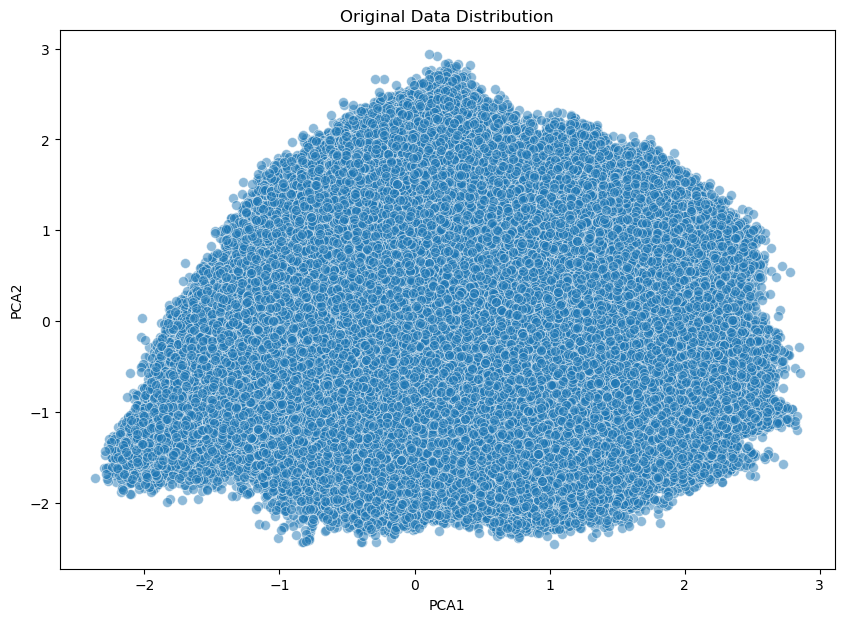

In [1]:
# 安装所需的库
# pip install rdkit pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 读取分子数据集（假设文件名为 molecules.csv 且包含一个 "SMILES" 列）
df = pd.read_csv('/raid/yyw/PharmDiGress/data/moses/moses_pyg/raw/train_moses.csv')

# 计算分子指纹
def calculate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        return np.array(fp)
    else:
        return None

df['Fingerprint'] = df['smiles'].apply(calculate_fingerprint)
df = df.dropna(subset=['Fingerprint'])

# 提取指纹矩阵
fingerprint_matrix = np.array(list(df['Fingerprint']))

# 使用PCA将指纹降维到2D
pca = PCA(n_components=2)
fingerprint_2d = pca.fit_transform(fingerprint_matrix)

# 将降维后的结果添加到数据框中
df['PCA1'] = fingerprint_2d[:, 0]
df['PCA2'] = fingerprint_2d[:, 1]

# 可视化原始数据的分布
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', data=df, s=50, alpha=0.5)
plt.title('Original Data Distribution')
plt.show()

In [12]:
# 使用KMeans聚类以帮助选择代表性样本
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=30, random_state=42, batch_size=100)
n_iterations = len(df) // 100

In [3]:
df.to_csv('/raid/yyw/PharmDiGress/data/moses/moses_pyg/raw/finger_moses_.csv')

In [13]:
from tqdm import tqdm
for i in tqdm(range(n_iterations), desc="KMeans Fitting Progress"):
    batch_data = fingerprint_2d[i * 100:(i + 1) * 100]
    kmeans.partial_fit(batch_data)


KMeans Fitting Progress:   0%|          | 0/15846 [00:00<?, ?it/s]/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
KMeans Fitting Progress: 100%|██████████| 15846/15846 [00:08<00:00, 1770.67it/s]


In [14]:
df['Cluster'] = kmeans.predict(fingerprint_2d)
# 从每个簇中随机选择样本以形成子集
subset_indices = df.groupby('Cluster').sample(frac=1/3, random_state=42).index
subset_df = df.loc[subset_indices]


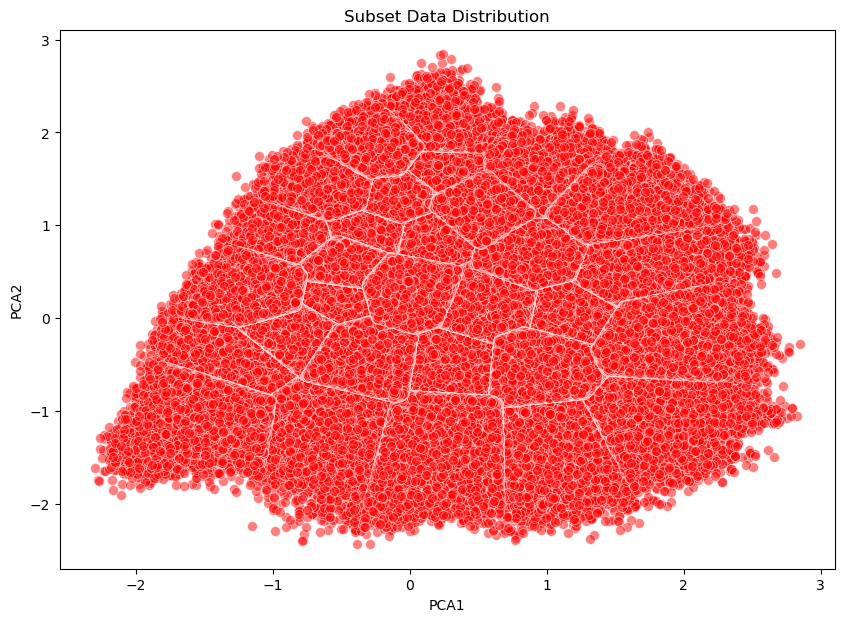

In [15]:

# 可视化子集的分布
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', data=subset_df, s=50, alpha=0.5, color='red')
plt.title('Subset Data Distribution')
plt.show()

# 保存子集
subset_df.to_csv('/raid/yyw/PharmDiGress/data/moses/moses_pyg/raw/subset_molecules.csv', index=False)

In [1]:
import torch
from tqdm import tqdm
import pandas as pd

from src.datasets.pharmacophore_eval import match_score
from dgl.data.utils import load_graphs
from rdkit import Chem
import csv
pp_graph_list1, _ = load_graphs("./data/GLP1_pdb/glp1_phar_graphs.bin")
for pp_graph1 in pp_graph_list1:
    pp_graph1.ndata['h'] = \
        torch.cat((pp_graph1.ndata['type'], pp_graph1.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph1.edata['h'] = pp_graph1.edata['dist'].reshape(-1, 1).float()
pp_graph_list2, _ = load_graphs("./data/Cav32_pdb/cav32_phar_graphs.bin")
for pp_graph in pp_graph_list2:
    pp_graph.ndata['h'] = \
        torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
    pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
# pp_graph_list3, _ = load_graphs("./data/HPK1_pdb/hpk1_phar_graphs.bin")
# for pp_graph1 in pp_graph_list3:
#     pp_graph1.ndata['h'] = \
#         torch.cat((pp_graph1.ndata['type'], pp_graph1.ndata['size'].reshape(-1, 1)), dim=1).float()
#     pp_graph1.edata['h'] = pp_graph1.edata['dist'].reshape(-1, 1).float()
# pp_graph_list4, _ = load_graphs("./data/LRRK2_pdb/lrrk2_phar_graphs.bin")
# for pp_graph in pp_graph_list4:
#     pp_graph.ndata['h'] = \
#         torch.cat((pp_graph.ndata['type'], pp_graph.ndata['size'].reshape(-1, 1)), dim=1).float()
#     pp_graph.edata['h'] = pp_graph.edata['dist'].reshape(-1, 1).float()
suppl = Chem.SDMolSupplier('./data/csd/raw/CSD_process.sdf', removeHs=False, sanitize=True)
mols = [mol for mol in suppl]
# test_dataset = './data/csd/CSD_prop.cszv
# with open(test_dataset, 'r+', newline='') as csvfile:
#     reader = csv.reader(csvfile)
#     next(reader)
with open('./data/csd/raw/csd_prop3.csv', 'a', newline='') as csvfile1:
    writer = csv.writer(csvfile1, delimiter=',')
    writer.writerow(['smiles', "glp1_score", 'cav32_score'])
    for mol in tqdm(mols, total=len(mols)):
        d1 = max([match_score(mol, pp_graph1) for pp_graph1 in pp_graph_list1])
        d2 = max([match_score(mol, pp_graph2) for pp_graph2 in pp_graph_list2])
        smile = Chem.MolToSmiles(mol)
        # d3 = max([match_score(mol, pp_graph3) for pp_graph3 in pp_graph_list3])
        # d4 = max([match_score(mol, pp_graph4) for pp_graph4 in pp_graph_list4])
        row = [smile,d1,d2]
        writer.writerow(row)

100%|██████████| 155042/155042 [191:53:07<00:00,  4.46s/it]        


In [2]:
from rdkit import Chem
suppl = Chem.SDMolSupplier('./data/csd/raw/CSD_process.sdf', removeHs=False, sanitize=True)
mols = [mol for mol in suppl]

[09:55:25] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:25] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:27] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:40] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:40] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:40] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:40] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:40] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[09:55:55] Warning: molecule is tagged as 3D, but all Z coords are zero
[09:55:57] Warning: molecule is tagged as 3D, but all Z coords are zero


In [3]:
len(mols)

184319

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES字符串
smiles = 'c123cl456789%10%11%12%13c%14%15%16%17%18%19%20%21o-4%22%23%24%25%26%27%28c=54%29%30%31%32%33%34c=15%35%36%37%38%39%40%41%42%43c#%22-41%44%45%46%47%48s-%144%22%49c6#%15=%29%14%50%51%52%53c#4#%16#56%15%29%54n=%30=%35-%2345=c=%36%16%23%30%35%55%56c=%17%36%57%58%59%60c#7#%37=%16%17#c#6-%237%16%37%61c%24#%18=%30=%31=%386%23%62%63%64c%25#%36=%15=%32-%14%18%24%30%31%38%65%66cl%14%15c7%19#%57#1#8#%39=6-%18%25%32c%16%35%50#%23#%24=%44-%17-%20-91(c%40=%55=%26-%22-%51-%10-%3067=c%31#%14#%37#%52=%62=%41-%58-c%61%45%11%38#%49#%25#1=%27=6-2-%338n#%56#%65=3=4=%59=%29=%63=%42-%46-%12=f%66#%53=%47=8-7-%64)c%60%54#%34#%13=%15=%48=%21=%43-5-%28-%32'

# 解析SMILES字符串
mol = Chem.MolFromSmiles(smiles)

# 可视化分子结构
Draw.MolToImage(mol)


[09:35:37] SMILES Parse Error: syntax error while parsing: c123cl456789%10%11%12%13c%14%15%16%17%18%19%20%21o-4%22%23%24%25%26%27%28c=54%29%30%31%32%33%34c=15%35%36%37%38%39%40%41%42%43c#%22-41%44%45%46%47%48s-%144%22%49c6#%15=%29%14%50%51%52%53c#4#%16#56%15%29%54n=%30=%35-%2345=c=%36%16%23%30%35%55%56c=%17%36%57%58%59%60c#7#%37=%16%17#c#6-%237%16%37%61c%24#%18=%30=%31=%386%23%62%63%64c%25#%36=%15=%32-%14%18%24%30%31%38%65%66cl%14%15c7%19#%57#1#8#%39=6-%18%25%32c%16%35%50#%23#%24=%44-%17-%20-91(c%40=%55=%26-%22-%51-%10-%3067=c%31#%14#%37#%52=%62=%41-%58-c%61%45%11%38#%49#%25#1=%27=6-2-%338n#%56#%65=3=4=%59=%29=%63=%42-%46-%12=f%66#%53=%47=8-7-%64)c%60%54#%34#%13=%15=%48=%21=%43-5-%28-%32
[09:35:37] SMILES Parse Error: Failed parsing SMILES 'c123cl456789%10%11%12%13c%14%15%16%17%18%19%20%21o-4%22%23%24%25%26%27%28c=54%29%30%31%32%33%34c=15%35%36%37%38%39%40%41%42%43c#%22-41%44%45%46%47%48s-%144%22%49c6#%15=%29%14%50%51%52%53c#4#%16#56%15%29%54n=%30=%35-%2345=c=%36%16%23%30%35%55%56c=%17

ValueError: Null molecule provided